# Classification Algorithm Analysis
Notebook to analyze data generated from `classification_algo` in `crawler.py`.

## Imports

In [2]:
import os
import pandas as pd
import json
import statistics
from pathlib import Path
import yaml
import matplotlib.pyplot as plt

from crawler import CrawlResults

from utils.utils import get_directories
from utils.image_shingle import ImageShingle

/tmp/ipykernel_596304/954183637.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [3]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

## Constants

In [4]:
CRAWL_NAME = '3N76L'
CRAWL_PATH = Path("/usr/project/xtmp/mml66/cookie-classify/") / CRAWL_NAME

###

with open(CRAWL_PATH / "meta.yaml", "r") as stream:
    meta = yaml.safe_load(stream)

CRAWL_NAME = meta['CRAWL_NAME']
SITE_LIST_PATH = meta['SITE_LIST_PATH']
NUM_CLICKSTREAMS = meta['NUM_CLICKSTREAMS']
CLICKSTREAM_LENGTH = meta['CLICKSTREAM_LENGTH']

meta

{'CLICKSTREAM_LENGTH': 5,
 'CRAWL_NAME': '3N76L',
 'NUM_CLICKSTREAMS': 10,
 'SITE_LIST_PATH': '3N76L-top-250.txt',
 'TRANCO': 'https://tranco-list.eu/list/3N76L/1000000'}

## Run Statistics

Check whether we actually crawled all of the sites in our original site list. If not, it is likely that one of the workers hanged or was killed.

In [5]:
# Sites that we wanted to crawl
sites_to_crawl = []
with open (CRAWL_PATH / SITE_LIST_PATH) as file:
    for line in file:
        sites_to_crawl.append(line.strip())

# Sites that we actually crawled
with open(CRAWL_PATH / "sites.json") as file:
    site_results: dict[str, CrawlResults] = json.load(file)

print(f"Crawled {len(site_results)}/{len(sites_to_crawl)} sites")
print("Missing", [site for site in sites_to_crawl if site not in site_results])

Crawled 231/250 sites
Missing ['forms.gle', 'cnn.com', 'salesforceliveagent.com', 'theguardian.com', 'mangosip.ru', 'bbc.co.uk', 'dns.google', 'rambler.ru', 'xiaomi.com', 'att.net', 'sciencedirect.com', 'mit.edu', 'slack.com', 'comfortel.pro', 'nginx.com', 'go.com', 'amazon.co.uk', 'issuu.com', 'launchdarkly.com']


Check which crawled sites were actually successful.
A successful site must have:
1. an available landing page
2. no unexpected crawl exceptions

In [12]:
successful_sites = []
for domain, result in site_results.items():
    result: CrawlResults
    if result["unexpected_exception"] is False and result["landing_page_down"] is False:
        successful_sites.append(domain)
print(f"Successfully crawled {len(successful_sites)}/{len(site_results)} sites")

akamaiedge.net
a-msedge.net
windowsupdate.com
amazonaws.com
akadns.net
akamai.net
tiktokcdn.com
trafficmanager.net
cloudflare.com
digicert.com
netflix.com
edgekey.net
t-msedge.net
doubleclick.net
cloudflare.net
live.com
aaplimg.com
yandex.ru
domaincontrol.com
lencr.org
l-msedge.net
root-servers.net
s-msedge.net
ytimg.com
gtld-servers.net
gvt2.com
outlook.com
google-analytics.com
tiktokv.com
apple-dns.net
msedge.net
microsoftonline.com
pki.goog
aiv-cdn.net
rbxcdn.com
e2ro.com
cdn-apple.com
cedexis.net
office365.com
hubspot.com
nflxso.net
yandex.net
whatsapp.com
bytefcdn-oversea.com
cdn77.org
amazon-adsystem.com
a2z.com
wac-msedge.net
adnxs.com
comcast.net
wsdvs.com
demdex.net
zoom.us
snapchat.com
mail.ru
cloudfront.net
edgesuite.net
paypal.com
shifen.com
edgecdn.ru
netflix.net
cdninstagram.com
cloudflare-dns.com
ttlivecdn.com
spo-msedge.net
msn.com
office.net
trbcdn.net
gvt1.com
msftncsi.com
cloudapp.net
akamaized.net
omtrdc.net
archive.org
nic.ru
nih.gov
one.one
ggpht.com
azurewebsites

### Time

In [7]:
total_time = {}
for domain, result in site_results.items():
    task_id = result["SLURM_ARRAY_TASK_ID"]
    if task_id not in total_time:
        total_time[task_id] = 0
    total_time[task_id] += result["total_time"] / 60  # convert to minutes

# Convert the dictionary into a DataFrame
df = pd.DataFrame(list(total_time.items()), columns=['SLURM_ARRAY_TASK_ID', 'Total_Crawl_Time_Minutes'])

# Sort the DataFrame by 'Total_Crawl_Time' in ascending order
df_sorted = df.sort_values(by='Total_Crawl_Time_Minutes', ascending=True)

# Display the sorted DataFrame
print(df_sorted)
print("Average time", df_sorted['Total_Crawl_Time_Minutes'].mean())



    SLURM_ARRAY_TASK_ID  Total_Crawl_Time_Minutes
6                    19                 17.289246
8                    25                 30.492258
16                   15                 45.586151
22                    5                 46.428983
0                     9                 67.801572
5                    10                 92.963973
2                    23                 94.573088
12                   11                 97.518142
1                     4                 98.690941
13                    2                107.889659
15                   13                110.528814
9                    21                113.765455
18                   14                116.716041
14                    8                116.930585
11                   12                118.215850
10                   18                119.006234
4                    22                129.012493
7                    16                132.049827
23                    7                132.958850


### Clickstream length
Statisistics for both clickstream generation and traversal.

In [6]:
import matplotlib.pyplot as plt

def generate_pie_chart(freq_dict, title=None):
    """
    Generates a pie chart from a frequency dictionary.

    Args:
        freq_dict (dict): A dictionary where keys are categories and values are frequencies.
        title (str): The title of the pie chart. If None, no title is displayed.

    Returns:
        None: Displays the pie chart.
    """
    # Sort the keys alphabetically
    sorted_keys = sorted(freq_dict.keys())

    # Generate a list of distinct colors
    # Note: Increase the number of colors if you have more categories
    colors = ['gold', 'lightcoral', 'lightskyblue', 'lightgreen', 'lavender', 'orange', 'cyan', 'pink', 'yellowgreen', 'plum']

    # Create a color map by assigning each key a color
    color_map = {key: colors[i % len(colors)] for i, key in enumerate(sorted_keys)}

    # Extract the labels (keys) and sizes (values) from the frequency dictionary
    labels = freq_dict.keys()
    sizes = freq_dict.values()
    
    # Get the list of colors based on the order of labels
    pie_colors = [color_map[label] for label in labels]

    # Generate the pie chart
    plt.figure(figsize=(4, 4))  # Set the figure size
    plt.pie(sizes, labels=labels, colors=pie_colors, autopct='%1.1f%%', startangle=140)
    plt.axis('equal')  # Equal aspect ratio ensures the pie chart is circular.
    
    if title:
        plt.title(title)

    # Display the pie chart
    plt.show()


Failed elements clicked by type.
This means we were able to generate the clickstream, but unable to traverse it again.

In [7]:
click_failures = {}

for site in successful_sites:
    for type, failures in site_results[site]['traversal_failures'].items():
        if type not in click_failures:
            click_failures[type] = 0
        click_failures[type] += failures

click_failures

{'button': 55, 'link': 263, 'onclick': 22, 'pointer': 428}

Elements clicked by type

In [8]:
from itertools import chain

click_types = {}
for site in successful_sites:
    for _, click_type in list(chain.from_iterable(site_results[site]['clickstream'])):
        if click_type is None:
            continue
        if click_type not in click_types:
            click_types[click_type] = 0
        click_types[click_type] += 1

click_types

{'pointer': 2615, 'link': 2577, 'button': 384, 'onclick': 115}

- Pointer elements are the most common element in our clickstreams.
- Links are the most reliable element that we can click on. (They are the only type that decreased in proportion.)

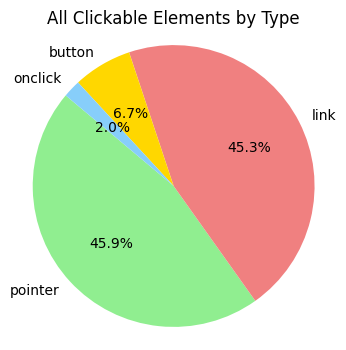

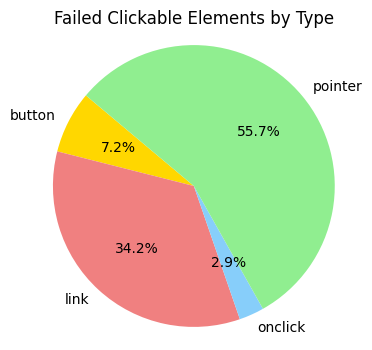

In [9]:
generate_pie_chart(click_types, title="All Clickable Elements by Type")
generate_pie_chart(click_failures, title="Failed Clickable Elements by Type")

Average clickstream length for each group.

- For baseline, this is the average length of the generated clickstream.
- For control and experimental, this is the average length of the successful traversal.

In [10]:
def count_actions(path: Path, name: str) -> int:
    count = 0
    
    while True:
        if (path / f"{name}-{count+1}.png").is_file(): # We add 1 since the first image is the landing page (not an action)
            count += 1
        else:
            return count

def get_clickstream_length() -> pd.DataFrame:
    rows_list = []

    for domain in successful_sites:
        clickstreams = get_directories(site_results[domain]["data_path"])

        baseline_actions = 0
        controls_actions = 0
        experimental_actions = 0
        for clickstream in clickstreams:
            baseline_actions += count_actions(clickstream, "baseline")
            controls_actions += count_actions(clickstream, "control")
            experimental_actions += count_actions(clickstream, "experimental")

        rows_list.append({
            "domain": domain,
            "baseline_actions": baseline_actions / NUM_CLICKSTREAMS,
            "control_actions": controls_actions / NUM_CLICKSTREAMS,
            "experimental_actions": experimental_actions / NUM_CLICKSTREAMS
        })

    return pd.DataFrame(rows_list)

clickstream_lengths = get_clickstream_length()

clickstream_lengths


,domain,baseline_actions,control_actions,experimental_actions
0,instagram.com,5.0,0.3,0.3
1,twitter.com,5.0,4.5,3.4
2,facebook.com,5.0,2.3,2.3
3,bing.com,5.0,2.8,2.9
4,icloud.com,5.0,5.0,5.0
5,youtube.com,5.0,3.1,3.3
6,googlevideo.com,5.0,4.5,4.4
7,amazon.com,5.0,0.5,0.5
8,gstatic.com,5.0,5.0,5.0
9,googleapis.com,5.0,5.0,5.0


In [11]:
print(f"Average baseline length: {clickstream_lengths['baseline_actions'].mean()}")
print(f"Average control length: {clickstream_lengths['control_actions'].mean()}")
print(f"Average experimental length: {clickstream_lengths['experimental_actions'].mean()}")

Average baseline length: 4.983478260869566
Average control length: 3.8504347826086955
Average experimental length: 3.761739130434783


## Analysis

This function is unused.

In [12]:
# def _compare_clickstreams(baseline: str, comparison: str, name: str) -> pd.DataFrame:
#     rows_list = []

#     for i, path in enumerate(successful_sites):
#         print(f"Analyzing site {i+1}/{len(successful_sites)}")
#         clickstreams = utils.get_directories(path)

#         sample_size = 0

#         total_clickstreams = 0
#         website_sum = 0

#         for clickstream in clickstreams:

#             total_actions = 0
#             clickstream_sum = 0

#             for _ in range(10):
#                 baseline_base_path = clickstream / f"{baseline}-{total_actions}"
#                 comparison_path = clickstream / f"{clickstream}/{comparison}-{total_actions}.png"
                
#                 if os.path.isfile(comparison_path):
#                     comparison_shingle = ImageShingle(comparison_path)

#                     max_similarity = 0
#                     for i in range(1, 11):
#                         baseline_path = f"{baseline_base_path}-{i}.png"
#                         if os.path.isfile(baseline_path):
#                             baseline_shingle = ImageShingle(baseline_path)
#                             max_similarity = max(max_similarity, baseline_shingle.compare(comparison_shingle))

#                     clickstream_sum += max_similarity
#                     total_actions += 1

#             sample_size += total_actions

#             if total_actions != 0:
#                 clickstream_similarity = clickstream_sum / total_actions
#                 website_sum += clickstream_similarity

#                 total_clickstreams += 1
        
#         if total_clickstreams != 0:
#             website_similarity = website_sum / total_clickstreams
#             website_difference = 1 - website_similarity

#             website = os.path.basename(os.path.normpath(path))
#             rows_list.append({
#                 "website": website,
#                 f"difference_{name}": website_difference,
#                 f"sample_size_{name}": sample_size
#             })

#     return pd.DataFrame(rows_list)

In [13]:
def screenshot_comparison() -> pd.DataFrame:
    rows_list = []

    for i, domain in enumerate(successful_sites):
        print(f"Analyzing site {i+1}/{len(successful_sites)}.")

        clickstreams = get_directories(site_results[domain]["data_path"])
        screenshot_sims = []
        for clickstream in clickstreams:
            for num_action in range(CLICKSTREAM_LENGTH+1):
                baseline_path = clickstream / f"baseline-{num_action}.png"
                control_path = clickstream / f"control-{num_action}.png"
                experimental_path = clickstream / f"experimental-{num_action}.png"
                
                if os.path.isfile(baseline_path) and os.path.isfile(control_path) and os.path.isfile(experimental_path):
                    CHUNK_SIZE = 40
                    baseline_shingle = ImageShingle(baseline_path, chunk_size = CHUNK_SIZE)
                    control_shingle = ImageShingle(control_path, chunk_size = CHUNK_SIZE)
                    experimental_shingle = ImageShingle(experimental_path, chunk_size = CHUNK_SIZE)

                    try:
                        screenshot_sims.append(ImageShingle.compare_with_control(baseline_shingle, control_shingle, experimental_shingle))
                    except ValueError as e:
                        print(e)
                else:
                    break

        if len(screenshot_sims) == 0:
            print(f"Skipping {domain} since no comparisons could be made.")
            continue

        screenshot_similarity = statistics.mean(screenshot_sims)
        sceenshot_difference = 1 - screenshot_similarity
        stdev = statistics.stdev(screenshot_sims)
        rows_list.append({
            "domain": domain,
            f"screenshot_difference": sceenshot_difference,
            f"stdev": stdev,
            f"samples": len(screenshot_sims),
        })

    return pd.DataFrame(rows_list)

screenshots = screenshot_comparison()
screenshots.to_csv("analysis/screenshots.csv", index=False)

Analyzing site 1/115.
Analyzing site 2/115.
Analyzing site 3/115.
Analyzing site 4/115.
Analyzing site 5/115.
Analyzing site 6/115.
Images must have the same number of shingles.
Images must have the same number of shingles.
Images must have the same number of shingles.
Images must have the same number of shingles.
Analyzing site 7/115.
Analyzing site 8/115.
Analyzing site 9/115.
Analyzing site 10/115.
Analyzing site 11/115.
Analyzing site 12/115.
Analyzing site 13/115.
Analyzing site 14/115.
Analyzing site 15/115.
Analyzing site 16/115.
Baseline and control are completely different.
Analyzing site 17/115.
Analyzing site 18/115.
Analyzing site 19/115.
Analyzing site 20/115.
Analyzing site 21/115.
Images must have the same number of shingles.
Images must have the same number of shingles.
Images must have the same number of shingles.
Images must have the same number of shingles.
Images must have the same number of shingles.
Images must have the same number of shingles.
Images must have th

In [9]:
df = pd.read_csv('analysis/screenshots.csv')
df.sort_values(by='screenshot_difference')

,domain,screenshot_difference,stdev,samples
112,openx.net,0.000000,0.000000,55
90,smartadserver.com,0.000000,0.000000,19
91,ubuntu.com,0.000000,0.000000,29
93,youtube-nocookie.com,0.000000,0.000000,60
24,sharepoint.com,0.000000,0.000000,20
55,apache.org,0.000000,0.000000,60
57,t.co,0.000000,0.000000,60
59,googledomains.com,0.000000,0.000000,56
69,app-measurement.com,0.000000,0.000000,60
70,health.mil,0.000000,0.000000,45


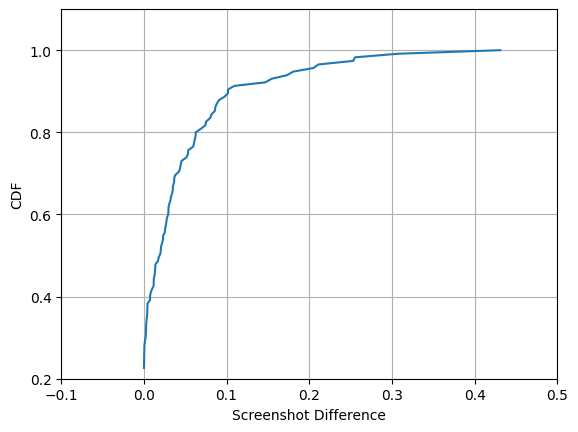

In [19]:
"""
Returns a dataframe which can be plotted as a CDF graph (see plot below).

args:
    list: list of values to plot
"""
def get_cdf(list):
    s = pd.Series(list, name = 'value')
    df = pd.DataFrame(s)

    # Frequency
    stats_df = df \
    .groupby('value') \
    ['value'] \
    .agg('count') \
    .pipe(pd.DataFrame) \
    .rename(columns = {'value': 'frequency'})

    # PDF
    stats_df['pdf'] = stats_df['frequency'] / sum(stats_df['frequency'])

    # CDF
    stats_df['cdf'] = stats_df['pdf'].cumsum()
    stats_df = stats_df.reset_index()

    return stats_df

import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)

%matplotlib inline

cdf_df = get_cdf(df['screenshot_difference'])

plt.plot(cdf_df['value'], cdf_df['cdf'], label='Screenshot Difference')

plt.axis([-0.1, 0.5, 0.2, 1.1])

plt.title('')
plt.xlabel('Screenshot Difference')
plt.ylabel('CDF')

# plt.legend(loc='upper left')

plt.grid(visible = True)

# plt.savefig(FIG_DIR+'/rejected_over_no_interaction_CDF.png', dpi=600, facecolor='white')
plt.show()

In [ ]:
def jaccard_similarity(dict1, dict2):
    # Calculate the intersection of keys
    intersection_keys = set(dict1.keys()).intersection(set(dict2.keys()))
    intersection_sum = sum(min(dict1.get(k, 0), dict2.get(k, 0)) for k in intersection_keys)

    # Calculate the union of keys
    union_keys = set(dict1.keys()).union(set(dict2.keys()))
    union_sum = sum(max(dict1.get(k, 0), dict2.get(k, 0)) for k in union_keys)

    # Calculate Jaccard similarity
    if union_sum == 0:
        return 0  # to handle division by zero

    return intersection_sum / union_sum

In [ ]:
def compare(list1: list[dict], list2: list[dict]):
    action_sims = []
    for dict1, dict2 in zip(list1, list2):
        action_sims.append(jaccard_similarity(dict1, dict2))

    return action_sims

In [ ]:
def compare_features(feature: str, comparison: tuple[str, str]) -> pd.DataFrame:
    rows_list = []

    for path in successful_sites:
        clickstreams = utils.get_directories(path)

        sample_size = 0
        all_action_sims = []
        for clickstream in clickstreams:
            data_path = f"{clickstream}/data.json"
            with open(data_path) as data:
                data = json.load(data)

            sample_size += min(len(data[feature][comparison[0]]), len(data[feature][comparison[1]]))
            all_action_sims.extend(compare(data[feature][comparison[0]], data[feature][comparison[1]]))

        website_similarity = statistics.mean(all_action_sims)
        stdev = statistics.stdev(all_action_sims)
        website_difference = 1 - website_similarity

        website = os.path.basename(os.path.normpath(path))
        rows_list.append({
            "website": website,
            f"mean diff": website_difference,
            f"stdev": stdev,
            f"samples": sample_size,
        })

    return pd.DataFrame(rows_list)

def merge_experiments(feature: str):
    A = compare_features(feature, ("baseline", "control"))
    B = compare_features(feature, ("baseline", "experimental"))
    diff = B["mean diff"] - A["mean diff"]

    df = pd.concat([A, B, diff], axis = 1, keys=(["control", "experimental", "difference in difference"]))
    df.name = feature
    return df

site_results: dict[str, None | pd.DataFrame] = {
    "innerText": None,
    "links": None,
    "img": None,
}
for feature in site_results:
    site_results[feature] = merge_experiments(feature)
    # results[feature].to_csv(f'analysis/{CRAWL_NAME}_{feature}.csv', index=False)


In [ ]:
site_results["innerText"]

In [ ]:
site_results["links"]

In [ ]:
site_results["img"]

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

def plot_comparison(df: pd.DataFrame, title: str):
    # Set the x-axis labels to be the websites
    websites = df["control"]["website"]
    x = np.arange(len(websites))  # Use numpy.arange for better control

    # Set the data for the second CSV (remove-third-party)
    mean_diff_control = df["control"]["mean diff"]
    stdev_control = df["control"]["stdev"]

    # Set the data for the first CSV (remove-all)
    mean_diff_experimental = df["experimental"]["mean diff"]
    stdev_experimental = df["experimental"]["stdev"]

    # Create the figure and axes for the plot
    _, ax = plt.subplots(figsize=(12, 6))

    # Define a color for the bars and error bars
    bar_color = "skyblue"

    # Width of the bars
    width = 0.35

    # Bars
    bars1 = ax.bar(x - width/2, mean_diff_control, width=width, label="Control", color="lightcoral", alpha=0.7)
    bars2 = ax.bar(x + width/2, mean_diff_experimental, width=width, label="Experimental", color=bar_color, alpha=0.7)

    # Set the x-axis labels
    ax.set_xticks(x)
    ax.set_xticklabels(websites, rotation=90)

    # Set labels and title
    ax.set_xlabel("Website")
    ax.set_ylabel("Mean Difference")
    ax.set_title(f"{title} feature comparison (10 clickstreams, length 5)")

    # Add a legend
    ax.legend()

    # Customize the error bars to match the bar color and add horizontal lines
    # error_kw = {'capsize': 5, 'ecolor': 'lightcoral', 'color': 'lightcoral'}
    # ax.bar(x - width/2, mean_diff_control, width=width, yerr=stdev_control, alpha=0, error_kw=error_kw)
    
    # error_kw = {'capsize': 5, 'ecolor': bar_color, 'color': bar_color}
    # ax.bar(x + width/2, mean_diff_experimental, width=width, yerr=stdev_experimental, alpha=0, error_kw=error_kw)

    # Add text labels for the values at the top of each bar
    for bar1, bar2 in zip(bars1, bars2):
        height1 = bar1.get_height()
        height2 = bar2.get_height()
        ax.annotate(f"{height1:.2f}", (bar1.get_x() + bar1.get_width() / 2, height1),
                    ha="center", va="bottom", fontsize=8)
        ax.annotate(f"{height2:.2f}", (bar2.get_x() + bar2.get_width() / 2, height2),
                    ha="center", va="bottom", fontsize=8)

    # Show the plot
    plt.tight_layout()
    plt.show()

for feature in site_results:
    plot_comparison(site_results[feature], feature)

In [ ]:
# Chunk comparison algorithm
# control_comparison = compare_with_control()

In [ ]:
# control_comparison.to_csv(f'analysis/{CRAWL_NAME}.csv', index=False)